# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [129]:
import json
import requests
#import requests_ftp
import requests_cache
import lxml
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk import corpus
from nltk.corpus import stopwords
from nltk import collocations
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
plt.style.use('ggplot')
requests_cache.install_cache('coll_cache')
%matplotlib inline

In [2]:
def link_list(url, page = 1):
    """
    Take url and page number (n) and return list of urls for articles on pages 1 to n from The Aggie. 
    Input: url in the form of https://theaggie.org/category, string; page, desired page numbers to request, integer
    Output: list of article url's from desired page numbers
    """
    pagereq = requests.get(url + '/page/' + str(page) + '/')
    pagehtml = pagereq.text
    pagebs = BeautifulSoup(pagehtml, 'lxml')
    page_content = pagebs.find_all(name='div',attrs={'class':'blog-grid-container'})
    pageset1 = page_content[0]
    pageset1_content = pageset1.find_all(name='div',attrs={'class':'content_wrapper'})
    apageset1 = []
    for i in range(len(pageset1_content)):
        apageset1.append(pageset1_content[i].find_all('a'))
    url_list = []
    for i in range(len(apageset1)):
        url_list.append(apageset1[i][0].attrs['href'])
    if page == 1:
        return url_list
    if page > 1:
        return url_list + link_list(url, page-1)            

In [107]:
test1 = link_list('https://theaggie.org/arts', 4)

In [4]:
print test1
print len(test1)

['https://theaggie.org/2017/01/26/presenting-hasan-minhaj/', 'https://theaggie.org/2017/01/26/who-is-u-s/', 'https://theaggie.org/2017/01/26/waltz-in-magic/', 'https://theaggie.org/2017/01/24/student-sounds-tempura/', 'https://theaggie.org/2017/01/23/the-hidden-museums-of-uc-davis/', 'https://theaggie.org/2017/01/23/aggie-style-watch-winter-edition/', 'https://theaggie.org/2017/01/22/modern-love/', 'https://theaggie.org/2017/01/22/la-la-land-review/', 'https://theaggie.org/2017/01/20/old-holiday-allows-for-new-traditions/', 'https://theaggie.org/2017/01/17/four-apps-to-help-foster-creativity-2/', 'https://theaggie.org/2017/01/16/a-workout-playlist/', 'https://theaggie.org/2017/01/15/fashion-trends-of-2017/', 'https://theaggie.org/2017/01/15/top-three-albums-of-2016/', 'https://theaggie.org/2017/01/12/davis-is-burning-fires-up-for-two-performances/', 'https://theaggie.org/2017/01/12/how-hallmark-has-mastered-the-holidays/', 'https://theaggie.org/2017/02/09/events-calendar-for-february/'

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

In [3]:
def article_info(url):
    """
    Takes url and extracts the title, text, and author of the corresponding Aggie article.
    input: url, string
    output: dictionary of title, text, author, and url, all strings
    """
    req = requests.get(url)
    reqhtml = req.text
    reqbs = BeautifulSoup(reqhtml, 'lxml')
    title = reqbs.find_all(name = 'h1', attrs = {'class':'entry-title'})
    title = title[0].getText().strip().encode('ascii', 'ignore')
    body = reqbs.find_all(name = 'div', attrs = {'itemprop': 'articleBody'})
    body_strings =  body[0].getText().strip().encode('ascii', 'ignore').splitlines()
    author = body_strings[-1]
    text = body_strings[1:len(body_strings)-1]
    text = ''.join(text)
    url = url
    article_dict = {'title':title, 'author':author, 'text':text, 'url':url}
    return article_dict

In [127]:
article_info('https://theaggie.org/2017/02/23/sacramentos-artstreet-exhibit-showcases-diverse-artwork/')

{'author': 'Written by: Pari Sagafi  arts@theaggie.org',
 'text': 'Dont miss this free exhibit ending on Saturday, Feb. 25Entering the partially-indoor, partially-outdoor world of Sacramentos ArtStreet exhibit, you are met with the largest wind chime youve probably ever seen, and you get to touch beautifully framed moss and have a glimpse at several colorful murals. The diverse art mediums  sculptures, decorated rooms, an interactive kaleidoscope  all blend together to resemble an Alice in Wonderland-esque theme park. Theres no denying that ArtStreet is weird, but its the good type of weird. Besides, what interesting art isnt a bit strange at the end of the day?Jose Di Gregorio, a professional artist whose exhibited art works include two murals and a laser cut piece installation, agrees that weird is good.PARI SAGAFI / COURTESYIm a self-proclaimed weirdo, and I want to own that term as a positive thing, I want my daughters to be weirdos, and I feel like when you can participate in a we

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [4]:
campus_list = link_list('https://theaggie.org/campus', 4)
city_list = link_list('https://theaggie.org/city', 4)

In [5]:
print len(campus_list)
print len(city_list)

60
60


In [6]:
def data_list(list):
    """
    input: list of article urls
    output: list of dictionaries, one for each article 
    """
    data = []
    for url in list:
        data.append(article_info(url))
    return data

In [7]:
campus_data = data_list(campus_list)

In [8]:
len(campus_data)

60

In [9]:
city_data = data_list(city_list)

In [10]:
len(city_data)

60

In [11]:
campus_df = pd.DataFrame.from_records(campus_data)
campus_df['category'] = 'campus'
campus_df.head()

,author,text,title,url,category
0,Written by: Lindsay Floyd campus@theaggie.org,Former plans paused in light of Katehis resign...,Napolitano to reinforce tentative plans to exp...,https://theaggie.org/2017/01/23/napolitano-to-...,campus
1,Written by: Ivan Valenzuela campus@theaggie.org,Feminist Research Institute nominates Linda Ka...,Former chancellor turns down feminist leadersh...,https://theaggie.org/2017/01/23/former-chancel...,campus
2,Written by: Yvonne Leong campus@theaggie.org,The first endowed brewer will be Joe WilliamsS...,Sierra Nevada Brewing owners gift $2 million t...,https://theaggie.org/2017/01/22/sierra-nevada-...,campus
3,Written by: Jayashri Padmanabhan campus@theag...,250 institutions ask new administration to add...,"Interim Chancellor Hexter, UC leaders sign let...",https://theaggie.org/2017/01/22/interim-chance...,campus
4,Written by: Jeanna Totah campus@theaggie.org,Higher education leaders stand by undocumented...,California schools press Donald Trump to conti...,https://theaggie.org/2017/01/22/california-sch...,campus


In [12]:
city_df = pd.DataFrame.from_records(city_data)
city_df['category'] = 'city'
city_df.head()

,author,text,title,url,category
0,Written by: Bianca Antunez city@theaggie.org,Davis community renews local parcel tax for K-...,"Measure H passes, voters support Davis schools",https://theaggie.org/2016/11/29/measure-h-pass...,city
1,Written by: Anya Rehon city@theaggie.org,"College alcohol use, high-risk drinking discus...",Local residents attend Davis town hall meeting,https://theaggie.org/2016/11/29/local-resident...,city
2,Written by: Sam Solomon city@theaggie.org,Looks like its been an interesting weekNov. 15...,Police Logs,https://theaggie.org/2016/11/27/police-logs-5/,city
3,Written by: Raul Castellanos Jr. city@theaggi...,Ornamental piano outside Mishkas Caf vandalize...,Public piano destroyed in act of vandalism,https://theaggie.org/2016/11/27/public-piano-d...,city
4,Written by: Samantha Solomon city@theaggie.org,"Davis residents light candles, promote sanctua...",Holding the Light,https://theaggie.org/2016/11/27/holding-the-li...,city


In [13]:
final_df = pd.concat([campus_df, city_df])
final_df = final_df.set_index('category')
final_df

,author,text,title,url
category,,,,
campus,Written by: Lindsay Floyd campus@theaggie.org,Former plans paused in light of Katehis resign...,Napolitano to reinforce tentative plans to exp...,https://theaggie.org/2017/01/23/napolitano-to-...
campus,Written by: Ivan Valenzuela campus@theaggie.org,Feminist Research Institute nominates Linda Ka...,Former chancellor turns down feminist leadersh...,https://theaggie.org/2017/01/23/former-chancel...
campus,Written by: Yvonne Leong campus@theaggie.org,The first endowed brewer will be Joe WilliamsS...,Sierra Nevada Brewing owners gift $2 million t...,https://theaggie.org/2017/01/22/sierra-nevada-...
campus,Written by: Jayashri Padmanabhan campus@theag...,250 institutions ask new administration to add...,"Interim Chancellor Hexter, UC leaders sign let...",https://theaggie.org/2017/01/22/interim-chance...
campus,Written by: Jeanna Totah campus@theaggie.org,Higher education leaders stand by undocumented...,California schools press Donald Trump to conti...,https://theaggie.org/2017/01/22/california-sch...
campus,Written by: Aaron Liss campus@theaggie.org,"UC Student Workers Union hosts walkout, teach-...","UC-wide walkout, teach-ins on Trumps inaugurat...",https://theaggie.org/2017/01/22/uc-wide-walkou...
campus,Written By: Lindsay Floyd campus@theaggie.org,"Some activists in favor of Yiannopoulos, other...",Protests erupt at Milo Yiannopoulos event,https://theaggie.org/2017/01/20/protests-erupt...
campus,Written by: Kenton Goldsby campus@theaggie.org,Speakers CeCe McDonald and Franchesca Ramsey k...,Student organizers host Change/The Conversatio...,https://theaggie.org/2017/01/20/student-organi...
campus,Written by: Lindsay Floyd campus@theaggie.org,"Napolitano expected to leave hospital soon, ma...",UC President Janet Napolitano hospitalized,https://theaggie.org/2017/01/19/uc-president-j...


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

__We will start by setting up some functions that will enable us to extract the most common words among the entire corpus, and also among subsets such as "city" and "campus" categories. __

In [69]:
def clean_words(text):
    """Takes a corpus and cleans it
    input: corpus
    output: list of words
    """
    stops = [unicode(word) for word in stopwords.words('english')] + ['uc', 'davis', 'students', 'said.', 'said', \
                                                                  'student', 'people', 'also', 'city', 'community']
    word_bag = text.apply(lambda t: t.lower() + " ").sum()
    words = [word for word in word_bag.split() if word.lower() not in stops]
    return words
    

In [70]:
def common_words(words):
    """Takes a list of words and returns a list of the 100 most common words in the corpus
    input: corpus
    output: list of most common words in corpus, with counts
    """
    return Counter(words).most_common()[:100] 

In [75]:
def bigram_words(words):
    """Takes a list of words and returns the most common bigrams
    input: list of words
    output: bigrams
    """
    bigram_measures = collocations.BigramAssocMeasures()
    bigram_finder = collocations.BigramCollocationFinder.from_words(words)
    bigram_finder.apply_freq_filter(20)
    l = []
    for bigram in bigram_finder.score_ngrams(bigram_measures.raw_freq)[:100]:
        l.append(bigram)
    return l

In [123]:
words_all = clean_words(final_df.text)
common_words_all = common_words(words_all)

In [106]:
common_words_all[0]

('one', 120)

In [76]:
bigram_all = bigram_words(words_all)
bigram_all

[(('yolo', 'county'), 0.0009844457570387872),
 (('mental', 'health'), 0.0009000646921497482),
 (('via', 'email.'), 0.0007031755407419908)]

In [122]:
words_campus = clean_words(final_df.text.campus)
common_words_campus = common_words(words_campus)

In [85]:
bigram_campus = bigram_words(words_campus)
bigram_campus

[(('mental', 'health'), 0.0014647944236791594),
 (('via', 'email.'), 0.0012627538135165169)]

In [121]:
words_city = clean_words(final_df.text.city)
common_words_city = common_words(words_city)

In [87]:
bigram_city = bigram_words(words_city)
bigram_city

[(('yolo', 'county'), 0.0021580450650587114)]

__It is interesting to see that the most common pairs of words among the campus articles are "mental health". The result of "yolo county" does not seem meaningful for the city corpus. We could try to eliminate more common words from the list of words, such as 'campus', or 'uc', or 'county', to get down to more substantial words. The plots and analysis for the most common words is at the end. We now compute the smooth idf and look at common words that way. __

In [77]:
stemmer = PorterStemmer().stem

tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

In [78]:
textd = {} #dictionary from lemmata to document ids containing that lemma
for i in range(len(final_df.text)):
    t = final_df.text[i]
    s = set(lemmatize(t))
    try:
        toks = toks | s
    except NameError:
        toks = s
    for tok in s:
        try:
            textd[tok].append(i)
        except KeyError:
            textd[tok] = [i]

In [79]:
docids = {} #dictionary of the document id to an integer id for the document
N = len(final_df.text)
for i in xrange(N):
    docids[i] = i
    
tokids = {} #dictionary of lemma to integer id for the lemma
tok_list = list(toks)
m = len(tok_list)
for j in xrange(m):
    tokids[tok_list[j]] = j

In [32]:
numd = {key:len(set(val)) for key,val in textd.items()}
logN = np.log(N)
idf_smooth = {key:logN - np.log(1 + val) for key, val in numd.items() if val > 1}
idf_smooth

{'1,800': 3.6888794541139358,
 u'hatr': 3.1780538303479453,
 'four': 2.3025850929940455,
 u'protest': 1.9542783987258296,
 'sleep': 3.6888794541139358,
 'asian': 3.401197381662155,
 'oldest': 3.6888794541139358,
 'hate': 2.2225423853205091,
 u'consider': 2.7080502011022101,
 'whose': 3.1780538303479453,
 'saylor': 3.6888794541139358,
 'voter': 3.6888794541139358,
 u'bike': 2.7080502011022101,
 'under': 1.6964492894237297,
 '@': 3.401197381662155,
 u'everi': 1.5293952047605637,
 'risk': 2.7080502011022101,
 u'compassion': 3.6888794541139358,
 'blanket': 3.6888794541139358,
 'rise': 3.1780538303479453,
 u'voic': 2.4849066497879999,
 u'tenni': 3.6888794541139358,
 'jack': 3.6888794541139358,
 u'unitran': 3.6888794541139358,
 u'govern': 1.9542783987258296,
 'jacob': 3.6888794541139358,
 u'affect': 1.9542783987258296,
 'school': 1.1765738301378215,
 u'scholar': 2.9957322735539909,
 u'showcas': 3.6888794541139358,
 u'environmentally-friendli': 3.6888794541139358,
 'enjoy': 1.9542783987258296

In [131]:
import operator
sorted_idf_smooth = sorted(idf_smooth.items(), key=operator.itemgetter(1))
sorted_idf_smooth

[('.', -0.0082988028146955273),
 ('in', -0.0082988028146955273),
 ('the', -0.0082988028146955273),
 ('and', 0.0),
 (',', 0.016807118316380709),
 ('to', 0.016807118316380709),
 ('a', 0.016807118316380709),
 ('on', 0.042559614418795633),
 ('of', 0.051293294387550148),
 ('is', 0.060103924069704995),
 ('for', 0.068992871486951657),
 ('with', 0.068992871486951657),
 ('that', 0.087011376989629241),
 (u'it', 0.09614386055290236),
 ('be', 0.10536051565782589),
 ('said', 0.12405264866997889),
 ('at', 0.14310084364067333),
 ('as', 0.16251892949777513),
 (u'thi', 0.18232155679395401),
 ('an', 0.18232155679395401),
 (u'have', 0.19237189264745602),
 (u'wa', 0.20252426411147351),
 (u'davi', 0.20252426411147351),
 ('are', 0.21278076427866299),
 ('by', 0.22314355131420971),
 ('not', 0.23361485118150505),
 ('from', 0.23361485118150505),
 ('we', 0.35667494393873245),
 (']', 0.36865113498544755),
 ('[', 0.36865113498544755),
 ('will', 0.38077249551779246),
 ('also', 0.43078291609245412),
 ('there', 0.443

__The first several are not meaningful words. We could go back and remove these words, but scrolling down we can see some more meaningful words, such as 'health', with an idf of 1.529, and 'learn' also with an idf of 1.529. 'Money', 'action', 'impact', and 'care' all have idf values of about 1.65. 'Against', 'love', and 'Trump' are also very common overall.__

(array([  18.,   10.,   22.,   14.,   23.,   29.,   41.,   41.,   81.,
          52.,  125.,   75.,  155.,   80.,  201.,  135.,  189.,  251.,
         349.,  807.]),
 array([-0.0082988 ,  0.17656011,  0.36141902,  0.54627794,  0.73113685,
         0.91599576,  1.10085467,  1.28571359,  1.4705725 ,  1.65543141,
         1.84029033,  2.02514924,  2.21000815,  2.39486706,  2.57972598,
         2.76458489,  2.9494438 ,  3.13430272,  3.31916163,  3.50402054,
         3.68887945]),
 <a list of 20 Patch objects>)

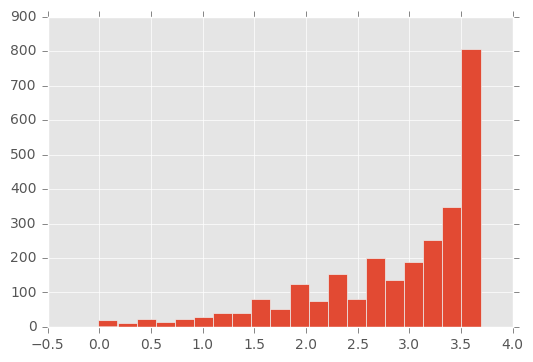

In [33]:
plt.hist(idf_smooth.values(),bins=20)

__Now we compute the similarity matrix and analyze the 3 pairs of articles that have the most highest similarity scores.__

In [34]:
corpus = [final_df.text[i] for i in range(len(final_df.text))]
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
tfs = vectorizer.fit_transform(corpus)

In [52]:
sim = tfs.dot(tfs.T) #similarity matrix
sim = sim.toarray()

In [53]:
np.where(sim == sim.max())

(array([31]), array([31]))

In [44]:
sim[31][31]

59814.910242948397

In [54]:
np.fill_diagonal(sim, 0)

In [55]:
np.where(sim == sim.max())

(array([20, 59]), array([59, 20]))

In [56]:
sim[20][59], sim[59][20] = 0,0

In [58]:
np.where(sim == sim.max())

(array([31, 59]), array([59, 31]))

In [59]:
sim[31][59], sim[59][31] = 0,0

In [60]:
np.where(sim == sim.max())

(array([11, 31]), array([31, 11]))

In [94]:
pair1 = final_df.iloc[[20,59],:].text

In [98]:
pair2 = final_df.iloc[[31,59],:].text

In [99]:
pair3 = final_df.iloc[[11,31],:].text

In [120]:
words_pair1 = clean_words(pair1)
common_words_pair1 = common_words(words_pair1)

In [101]:
bigram_pair1 = bigram_words(words_pair1)
bigram_pair1

[(('mental', 'health'), 0.028604118993135013)]

In [119]:
words_pair2 = clean_words(pair2)
common_words_pair2 = common_words(words_pair2)

In [103]:
bigram_pair2 = bigram_words(words_pair2)
bigram_pair2

[]

In [118]:
words_pair3 = clean_words(pair3)
common_words_pair3 = common_words(words_pair3)

In [105]:
bigram_pair3 = bigram_words(words_pair3)
bigram_pair3

[]

In [116]:
import seaborn as sns
def bar_plot(tuples):
    sns.set(style = 'whitegrid')
    f, ax = plt.subplots(figsize=(6, 15))
    word = zip(*tuples)[0]
    freq = zip(*tuples)[1]
    sns.set_color_codes("muted")
    sns.barplot(x=freq, y=word, color="b")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 150), ylabel="", xlabel="freq")
    sns.despine(left=True, bottom=True)
    return plt.show()

__Barplot for the most common words overall__ We can see that 'California', 'president', 'health', 'food', 'public', 'environmental', 'sexual', and 'mental' are among the most common words overall. So it appears that many of the topics were concerning the environment, the presidential elections, health, public, and perhaps other issues such as mental health and sexuality. 

/Users/pampatterson/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


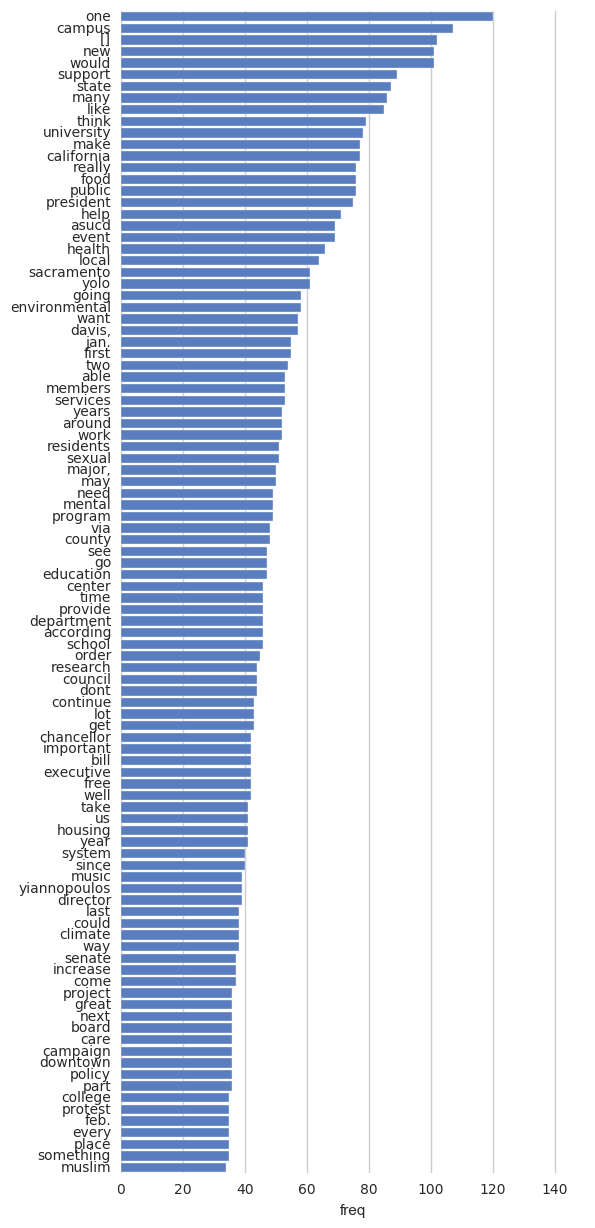

In [117]:
bar_plot(common_words_all)

__Bar plot of most common words for the campus category. __ We can see that 'sexual' is higher on the list along with 'health' and 'president'. It appears that many of the topics in the campus category may have been about the election, mental health, and the environment. 

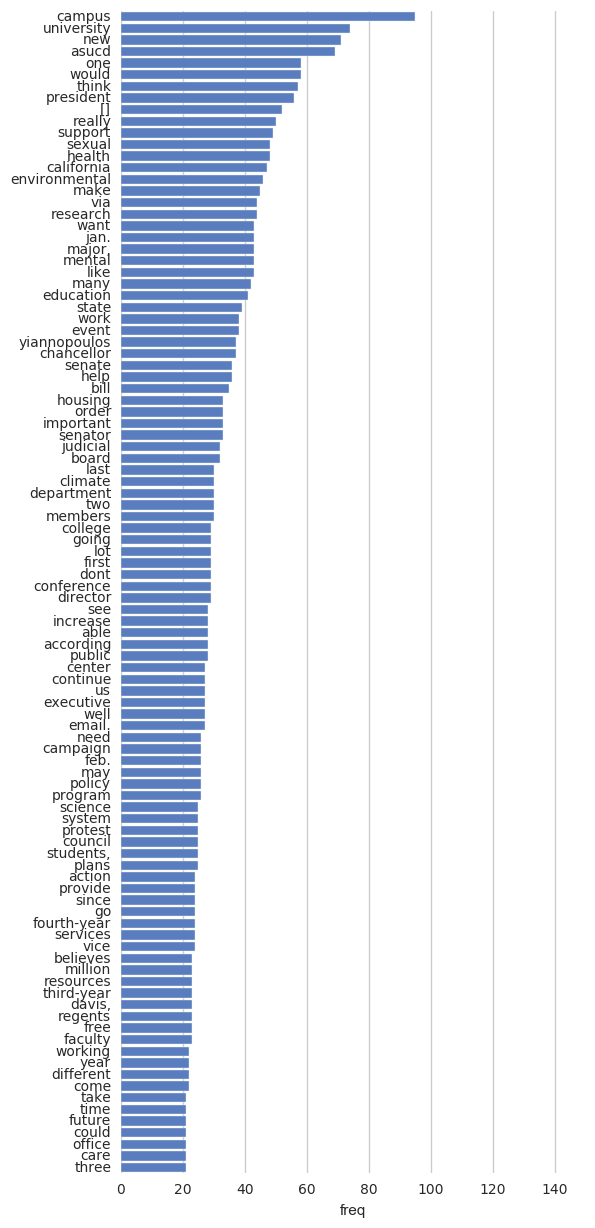

In [124]:
bar_plot(common_words_campus)

__Bar plot for most common words among city category.__ 'Residents' is high on the list, as well as 'support', 'services', and 'bike', while 'president' isn't as common as in the campus category. So it appears that the city and campus articles cover different topics. The city articles seem to be concerned with services and events happening in the city. 

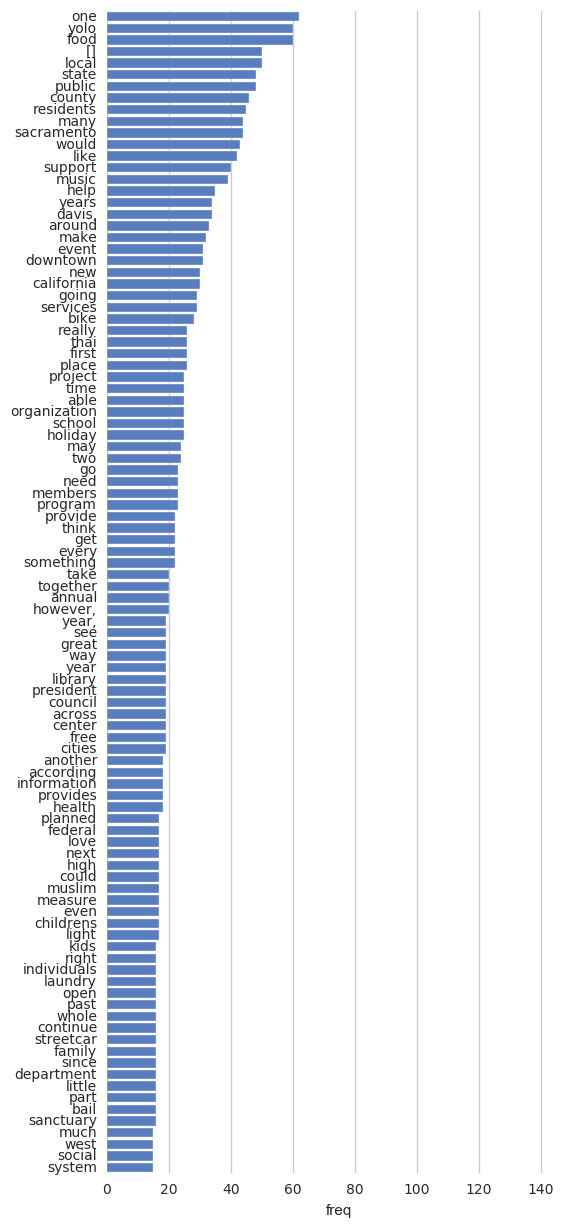

In [125]:
bar_plot(common_words_city)

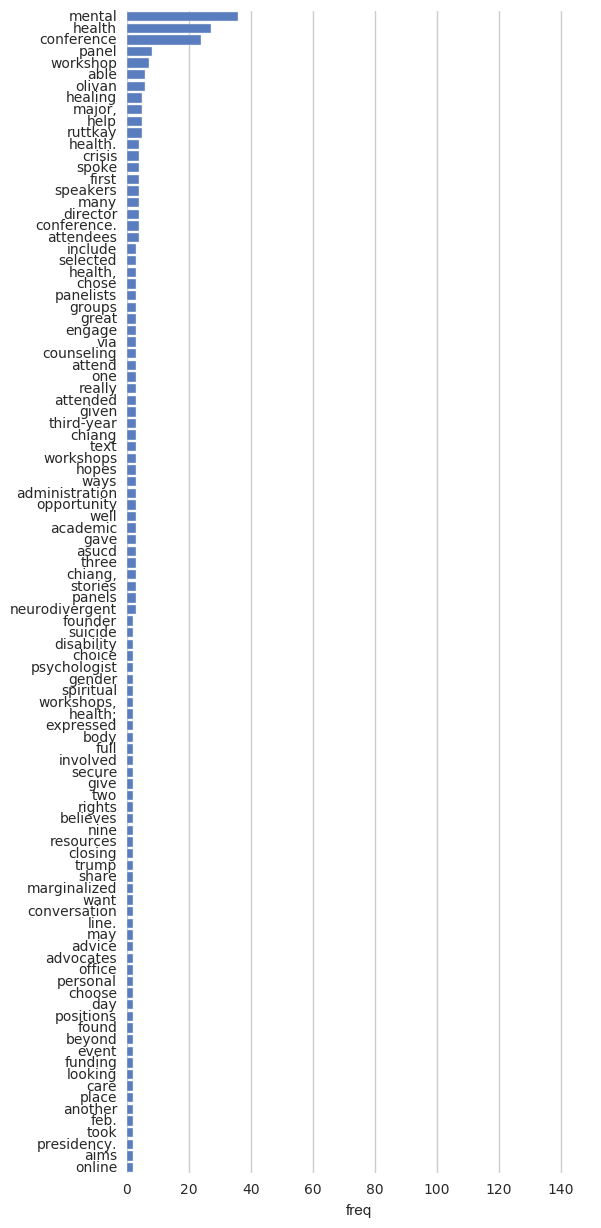

In [126]:
bar_plot(common_words_pair1)

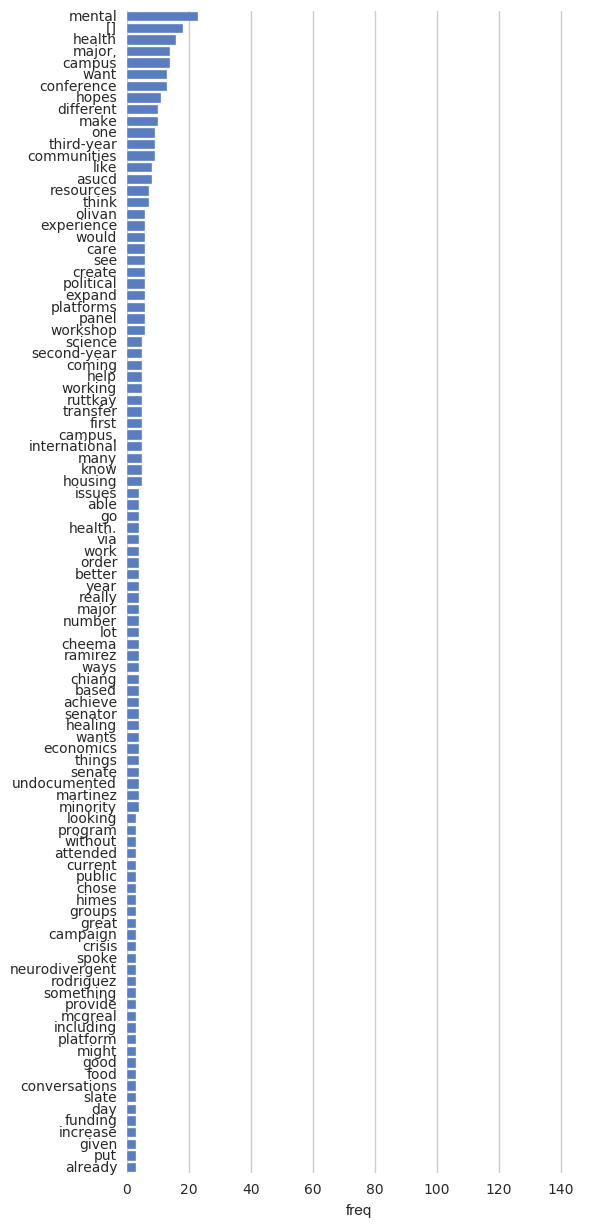

In [127]:
bar_plot(common_words_pair2)

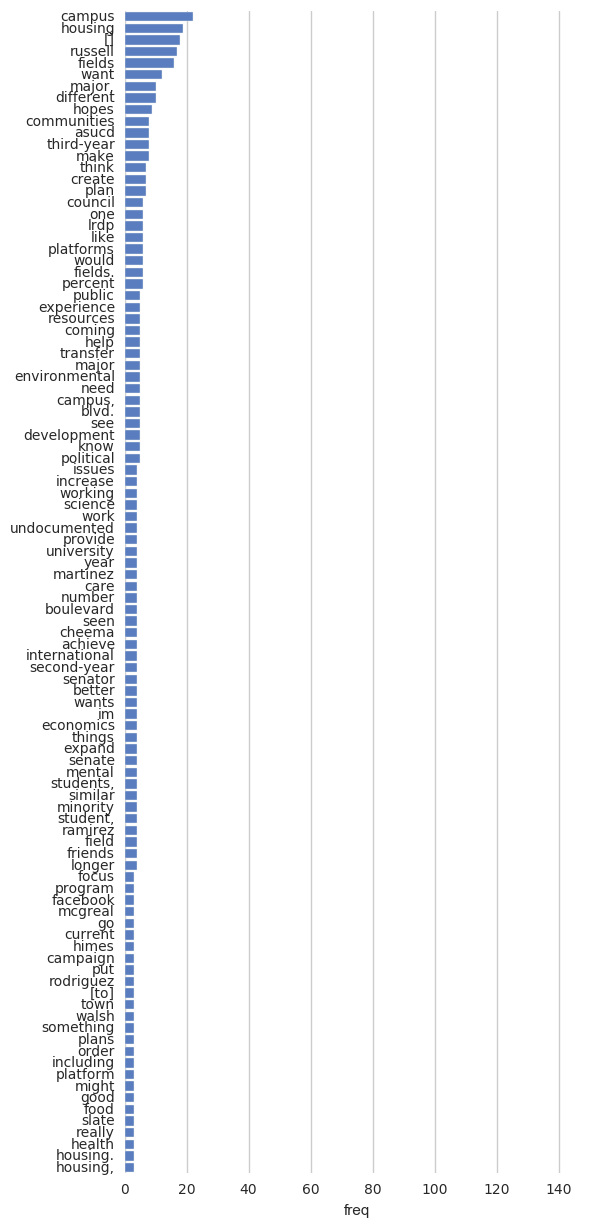

In [128]:
bar_plot(common_words_pair3)

The 3 pairs of articles are all very similar, as there is overlap among them. The first 2 appear to be about a conference and they both mention 'mental' and 'health' frequently. The third pair seem to focus on campus housing as those are the two most common words. 

I think this corpus is only representative of the 'city' and 'campus' portion of the Aggie. To get a more substantial inference, we should include more categories, such as 'arts' and 'sports'. These are both important concerns to students and should be represented in a school newspaper analysis. 